In [1]:
import numpy as np
import pandas as pd
from EMDPM.model_generator import generate_logistic_model
from EMDPM.synthetic_data_generator import generate_synthetic_data
from EMDPM.visualization import (
    plot_biomarker_trajectories,
    plot_true_observations,
    plot_initial_beta_guess,
    plot_theta_fit_comparison,
    plot_theta_error_history,
    plot_beta_overlay,
    plot_beta_error_history,
    plot_lse,
    plot_cog_regression_history
)
from EMDPM.utils import solve_system
from EMDPM.em_transformer_rework import EM
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv("/data01/bgutman/MRI_data/PPMI/data_ppmi_pd.csv")
df_K = pd.read_csv("/data01/bgutman/LEGACY/Skoltech/datasets/Connectomes/mean_NORM_con_22.csv")

## remove non-longitudinal observations
print("original size:", df.shape)
relevant_cols = [col for col in df.columns if col.startswith(('L_', 'R_')) and ('_thickavg' in col or '_thickavg_resid' in col)]
relevant_cols += ["MCATOT", "TD_score", "PIGD_score"]
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=relevant_cols)

print("after drop na", df.shape)
subj_counts = df['subj_id'].value_counts()
num_unique = (subj_counts == 1).sum()
print("one time subj_id:", num_unique)

longitudinal_ids = subj_counts[subj_counts > 1].index
df = df[df['subj_id'].isin(longitudinal_ids)].copy()
df = df.drop_duplicates(subset=["subj_id", "time"])
print("after drop dupes", df.shape)

X = df[[col for col in df.columns if (col.startswith(('L_', 'R_')) and col.endswith('_thickavg') and not col.endswith('_thickavg_resid'))]]
X_resid = df[[col for col in df.columns if (col.startswith(('L_', 'R_')) and col.endswith('_thickavg_resid'))]]

X = X.to_numpy()
X_resid = X_resid.to_numpy()

print("nans in X:", np.isnan(X).sum())
print("infs in X:", np.isinf(X).sum())

print("nans X_resid:", np.isnan(X_resid).sum())
print("infs X_resid:", np.isinf(X_resid).sum())

## connectivity matrix to numpy
K = df_K.drop(df_K.columns[0], axis=1).to_numpy()
np.fill_diagonal(K, 0)
print(K.shape, type(K))

# normalization
row_sums = K.sum(axis=1)
median_row_sum = np.median(row_sums)
K = K / median_row_sum

t_max = 20
step = 0.001

print("X.size: ", X.shape, "X_resid.size: ", X_resid.shape)

ids = df["subj_id"].to_numpy()
dt = df["time"].to_numpy()/12 # convert to years
#cog = df["MCATOT"].values#,"TD_score","PIGD_score"]].values
cog = df[["MCATOT","TD_score","PIGD_score"]].to_numpy()

print("nans in cog:", np.isnan(cog).sum())
print("infs in cog:", np.isinf(cog).sum())

original size: (880, 250)
after drop na (868, 250)
one time subj_id: 227
after drop dupes (504, 250)
nans in X: 0
infs in X: 0
nans X_resid: 0
infs X_resid: 0
(68, 68) <class 'numpy.ndarray'>
X.size:  (504, 68) X_resid.size:  (504, 68)
nans in cog: 0
infs in cog: 0


In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input


X_nn = df[["MCATOT", "TD_score", "PIGD_score"]].to_numpy()
y_stage = df["NHY"].to_numpy()
y_norm = (y_stage - y_stage.min()) / (y_stage.max() - y_stage.min())

model = tf.keras.Sequential([
    Input(shape=(X_nn.shape[1],)),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')  # iutput is [0, 1]
])

model.compile(optimizer='adam', loss='mse')
model.fit(X_nn, y_norm, epochs=100, batch_size=16, verbose=0)
beta_init = model.predict(X_nn) * t_max



2025-06-18 11:31:36.993471: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-18 11:31:37.015240: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-18 11:31:37.021853: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-18 11:31:37.039131: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-18 11:31:38.068196: W tensorflow/compiler/tf2

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


504


(array([119., 147., 111.,  65.,  28.,   7.,   9.,   2.,   2.,   0.,   2.,
          0.,   4.,   4.,   1.,   0.,   1.,   0.,   0.,   2.]),
 array([ 7.04566002,  7.57682705,  8.10799408,  8.63916111,  9.17032814,
         9.70149422, 10.23266125, 10.76382828, 11.29499531, 11.82616234,
        12.35732937, 12.8884964 , 13.41966343, 13.95083046, 14.48199749,
        15.01316452, 15.5443306 , 16.07549858, 16.60666466, 17.13783264,
        17.66899872]),
 <BarContainer object of 20 artists>)

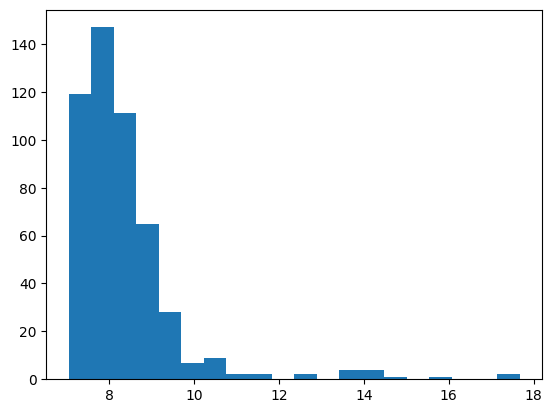

In [4]:
print(np.size(beta_init))
plt.hist(beta_init, bins=20)

In [5]:
initial_beta = np.zeros_like(np.unique(ids))

for idx, pid in enumerate(np.unique(ids)):
    mask = (pid == ids)
    beta_i = min(beta_init[mask])
    initial_beta[idx] = beta_i    
    


path = "/home/dsemchin/Progression_models_simulations/EMDPM/experiments/real_data_PPMI/ppmi_iter50_jac1_cog0_f01_sk001_betaNN"
em_model_0 = EM(num_iterations=50, t_max=t_max, step=step,
                 use_jacobian=True, lambda_cog=0.0, lambda_f=0.1, lambda_scalar=0.01)
em_model_0.fit(X=X, dt=dt, ids=ids, cog=cog, K=K, save_path=path, initial_beta=initial_beta)

initial conditions:
n_patients: 146, n_obs: 504
initial f: [0.02132917 0.0153129  0.06642505 0.06843318 0.09331644 0.075149
 0.09268624 0.09472834 0.0866778  0.0012602  0.04133209 0.08230453
 0.0022666  0.01390147 0.09860839 0.09937478 0.08214235 0.08432822
 0.04013177 0.06671307 0.08373361 0.09839783 0.02023919 0.03501122
 0.04284144 0.01783596 0.09961038 0.09075806 0.02514527 0.00911193
 0.08359398 0.01764515 0.01661423 0.07885973 0.07766215 0.04404987
 0.09696822 0.082177   0.05962018 0.00122331 0.05374854 0.04256232
 0.04619497 0.04704044 0.02556865 0.01364169 0.04599744 0.07974691
 0.07593373 0.03570143 0.06885477 0.07627636 0.07265386 0.08249544
 0.09601051 0.04935155 0.06479739 0.06791427 0.02254441 0.00444622
 0.03445908 0.07018692 0.06961764 0.09191688 0.02265776 0.09207324
 0.06548166 0.07676195]
initial s: [0.10711755 0.28260825 2.16554111 1.09902366 1.78421727 2.15874837
 1.36243194 1.69084338 2.16695433 1.00498682 0.94543585 1.55525368
 2.5998545  1.57441885 1.22037802 2.6

/tmp/ipykernel_9989/249864558.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  initial_beta[idx] = beta_i


prepend complete


  0%|          | 0/50 [00:00<?, ?it/s]

[  -210.63389135   -506.48728689   -394.01713924 -10191.95549028
  -2485.95408479  -7539.89697748  -1115.8596708   -1010.83630108
    -59.60515418   -922.046848    -1154.80451187   -747.48625107
    630.70736057  -1914.4358118   -1175.35939504   1179.97710569
   -619.03103179   -515.93088225  -2232.77683021    931.06447137
   -829.91860295   -776.20789151   -919.68218581   -727.07576019
   -855.01372423   -877.60946733   -340.74739361   -277.13742343
    493.64374419   -648.75114134   -307.17412022  -1980.64817669
  -1520.85496611   -852.98607119   -758.94901793  -1197.5979015
     97.35881932   -392.49838963 -30227.79591804   -297.25781151
  -6862.0430425    -583.25235923   -824.4715326     581.3898473
   -816.25073957    536.57698633  -1684.05120559   -268.49440961
    636.87568396   -379.5328028   -2222.6184038     727.98638757
    710.50178787   -805.4056464    -900.12564407   1564.85159939
  -1164.64972431   -799.93447324    321.72970491   -694.75448317
    181.31448417   -174.489

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 2 has 0 dimension(s)

initial theta:
f:  [0.021 0.015 0.066 0.068 0.093 0.075 0.093 0.095 0.087 0.001]
s:  [0.107 0.283 2.166 1.099 1.784 2.159 1.362 1.691 2.167 1.005]
s_k:  4.149
final theta:
f:  [1.212 1.263 0.264 2.307 1.618 1.518 0.912 0.725 0.114 0.845]
s:  [2.386 2.335 2.437 1.897 3.136 2.624 2.323 2.639 2.205 2.156]
s_k:  4.177739572577911
n_zeros: 0


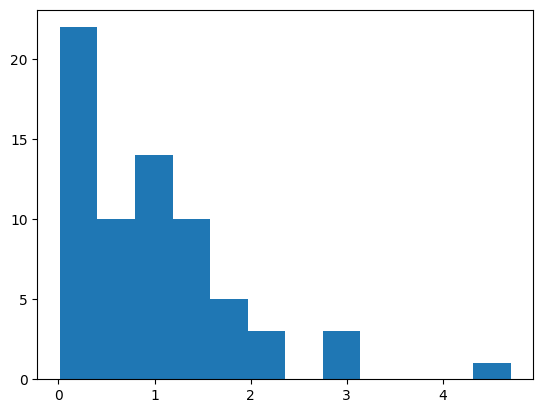


BETA SUMMARY:
beta initial:  [ 8.  7.  7.  7.  7.  7.  8.  7. 10.  7.]
beta final:  [ 8.  7.  7.  7.  7.  7.  8.  7. 10.  7.]


/home/dsemchin/Progression_models_simulations/EMDPM/visualization.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


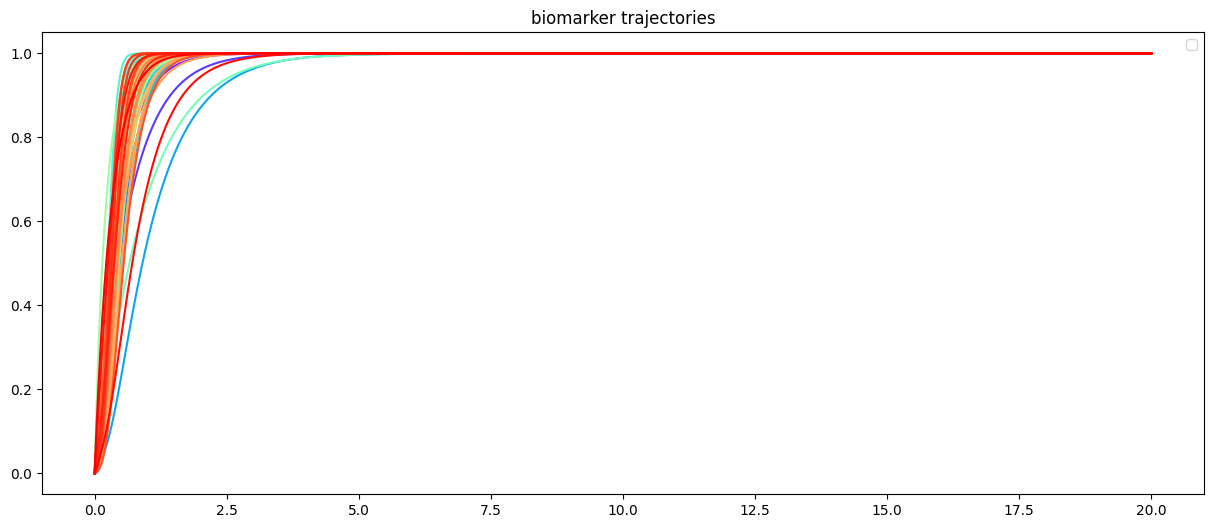

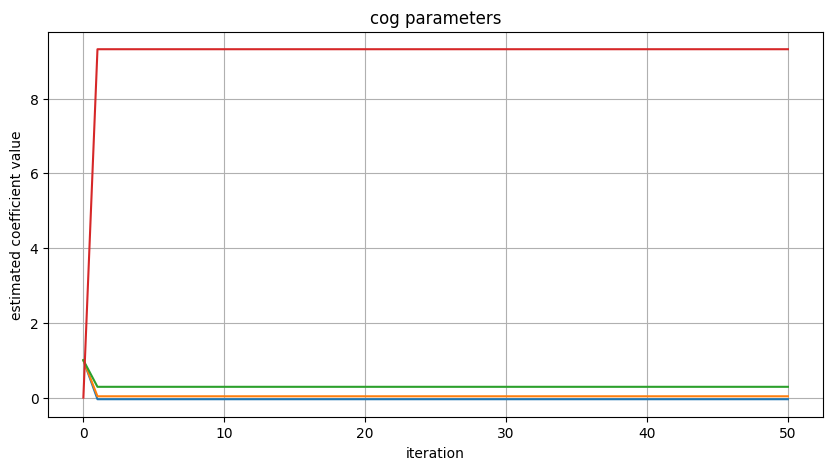

In [ ]:
n_biomarkers = 68
t_span = np.linspace(0, t_max, int(t_max/step))

theta_history = em_model_0.theta_history
beta_history = em_model_0.beta_history
lse_history = em_model_0.lse_history

# final params
final_theta = theta_history[:,-1]
final_x0 = np.zeros(n_biomarkers)
final_f = final_theta[0:n_biomarkers]
final_s = final_theta[n_biomarkers:2*n_biomarkers]
final_scalar_K = final_theta[-1]
final_model = solve_system(final_x0, final_f, K, t_span, final_scalar_K)

initial_theta = theta_history[:,0]
initial_x0 = np.zeros(n_biomarkers)
initial_f = initial_theta[0:n_biomarkers]
initial_s = initial_theta[n_biomarkers:2*n_biomarkers]
initial_scalar_K = initial_theta[-1]
#initial_model = solve_system(initial_x0, initial_f, K, t_span, initial_scalar_K)

print("initial theta:")
print("f: ", np.round(initial_theta[:n_biomarkers], 3)[0:10])
print("s: ", np.round(initial_theta[n_biomarkers:2*n_biomarkers], 3)[0:10])
print("s_k: ", initial_theta[-1])

print("final theta:")
print("f: ", np.round(final_theta[:n_biomarkers], 3)[0:10])
print("s: ", np.round(final_theta[n_biomarkers:2*n_biomarkers], 3)[0:10])
print("s_k: ", final_theta[-1])

zeros = np.sum(final_theta[:n_biomarkers] == 0.0)
print(f"n_zeros: {zeros}")
plt.figure()
plt.hist(final_theta[:n_biomarkers], bins=12) 
plt.show()

## Beta comparison:
print("\nBETA SUMMARY:")
print("beta initial: ", np.round(beta_history[0:10, 0], 3))
print("beta final: ", np.round(beta_history[0:10, -1], 3))

plot_biomarker_trajectories(final_model, t_span, n_biomarkers)
plot_cog_regression_history(em_model_0.cog_regression_history, ["MCATOT","TD_score","PIGD_score"])

In [ ]:
path = "/home/dsemchin/Progression_models_simulations/EMDPM/experiments/real_data_PPMI/ppmi_iter50_jac1_cog0_f01_sk01_betaNN"
em_model_1 = EM(num_iterations=50, t_max=t_max, step=step,
                 use_jacobian=True, lambda_cog=0.0, lambda_f=0.1, lambda_scalar=0.1)
em_model_1.fit(X=X, dt=dt, ids=ids, cog=cog, K=K, save_path=path, initial_beta=initial_beta)

initial conditions:
n_patients: 146, n_obs: 504
initial f: [0.02132917 0.0153129  0.06642505 0.06843318 0.09331644 0.075149
 0.09268624 0.09472834 0.0866778  0.0012602  0.04133209 0.08230453
 0.0022666  0.01390147 0.09860839 0.09937478 0.08214235 0.08432822
 0.04013177 0.06671307 0.08373361 0.09839783 0.02023919 0.03501122
 0.04284144 0.01783596 0.09961038 0.09075806 0.02514527 0.00911193
 0.08359398 0.01764515 0.01661423 0.07885973 0.07766215 0.04404987
 0.09696822 0.082177   0.05962018 0.00122331 0.05374854 0.04256232
 0.04619497 0.04704044 0.02556865 0.01364169 0.04599744 0.07974691
 0.07593373 0.03570143 0.06885477 0.07627636 0.07265386 0.08249544
 0.09601051 0.04935155 0.06479739 0.06791427 0.02254441 0.00444622
 0.03445908 0.07018692 0.06961764 0.09191688 0.02265776 0.09207324
 0.06548166 0.07676195]
initial s: [0.10711755 0.28260825 2.16554111 1.09902366 1.78421727 2.15874837
 1.36243194 1.69084338 2.16695433 1.00498682 0.94543585 1.55525368
 2.5998545  1.57441885 1.22037802 2.6

  4%|▍         | 2/50 [01:07<25:10, 31.47s/it]

  6%|▌         | 3/50 [10:11<3:28:03, 265.60s/it]

100%|██████████| 50/50 [18:50<00:00, 22.62s/it]  


SUMMARY:
initial theta:  [0.02132917 0.0153129  0.06642505 0.06843318 0.09331644 0.075149
 0.09268624 0.09472834 0.0866778  0.0012602 ]
final theta:  [2.84705155e+00 7.28961811e-01 7.29327778e-01 1.60601573e+01
 2.86306126e+00 1.18901903e+01 8.24002142e-01 5.29902612e-01
 5.57517919e-09 8.05020662e-09]
Saved histories to /home/dsemchin/Progression_models_simulations/EMDPM/experiments/real_data_PPMI/ppmi_iter50_jac1cog001_NN.npz


EM(lambda_cog=0.01, rng=Generator(PCG64) at 0x7F56645CE180, step=0.001,
   t_max=20, use_jacobian=True)

initial theta:
f:  [0.021 0.015 0.066 0.068 0.093 0.075 0.093 0.095 0.087 0.001]
s:  [0.107 0.283 2.166 1.099 1.784 2.159 1.362 1.691 2.167 1.005]
s_k:  4.149
final theta:
f:  [ 2.847  0.729  0.729 16.06   2.863 11.89   0.824  0.53   0.     0.   ]
s:  [2.386 2.335 2.437 1.897 3.136 2.624 2.323 2.639 2.205 2.156]
s_k:  89.9863312833171
n_zeros: 2


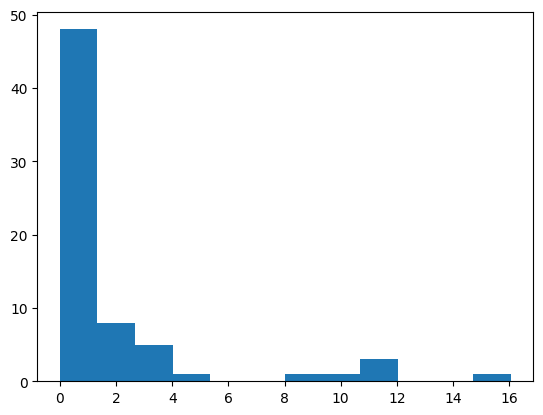


BETA SUMMARY:
beta initial:  [ 8.746  5.054  9.18   3.812  3.025 19.085 12.867  3.925  4.536  1.359]
beta final:  [ 8.746  5.054  9.18   3.812  3.025 19.085 12.867  3.925 20.     1.359]


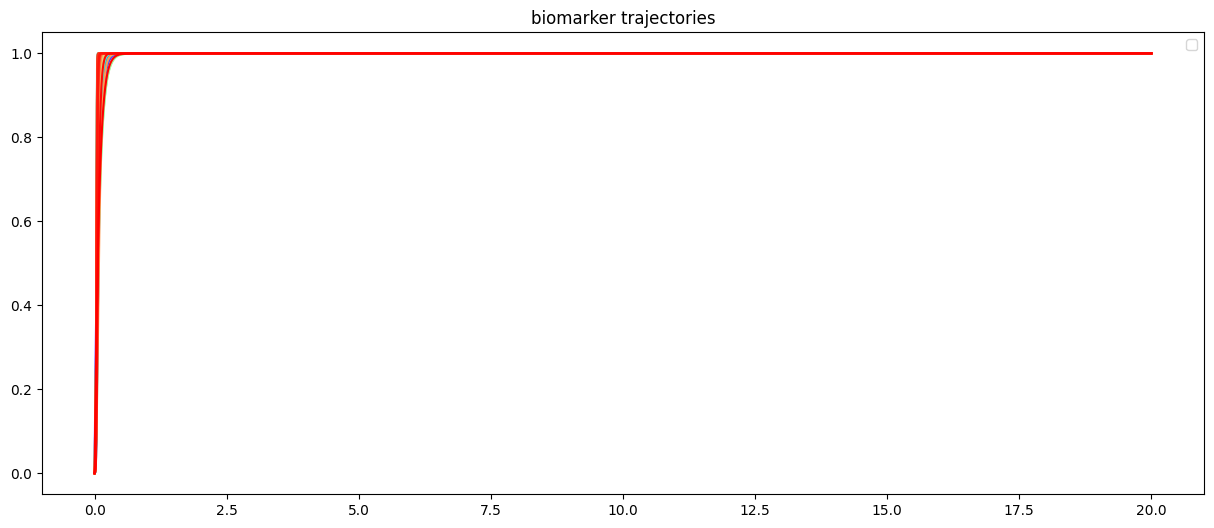

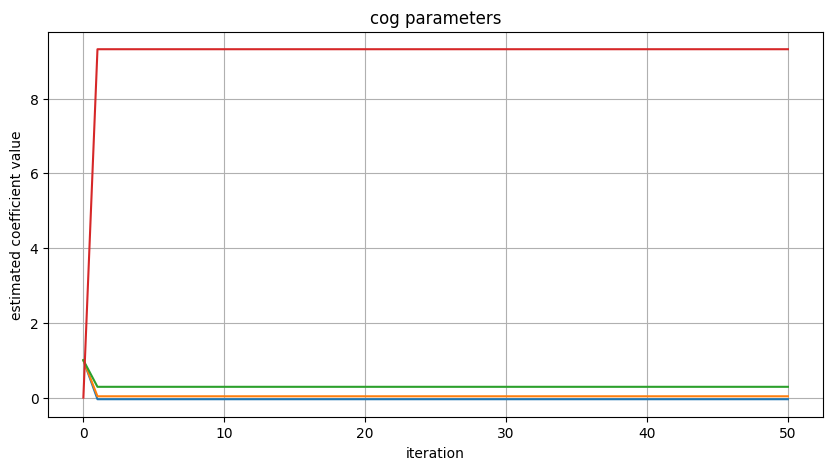

In [ ]:
n_biomarkers = 68
t_span = np.linspace(0, t_max, int(t_max/step))

theta_history = em_model_1.theta_history
beta_history = em_model_1.beta_history
lse_history = em_model_1.lse_history

# final params
final_theta = theta_history[:,-1]
final_x0 = np.zeros(n_biomarkers)
final_f = final_theta[0:n_biomarkers]
final_s = final_theta[n_biomarkers:2*n_biomarkers]
final_scalar_K = final_theta[-1]
final_model = solve_system(final_x0, final_f, K, t_span, final_scalar_K)

initial_theta = theta_history[:,0]
initial_x0 = np.zeros(n_biomarkers)
initial_f = initial_theta[0:n_biomarkers]
initial_s = initial_theta[n_biomarkers:2*n_biomarkers]
initial_scalar_K = initial_theta[-1]
#initial_model = solve_system(initial_x0, initial_f, K, t_span, initial_scalar_K)

print("initial theta:")
print("f: ", np.round(initial_theta[:n_biomarkers], 3)[0:10])
print("s: ", np.round(initial_theta[n_biomarkers:2*n_biomarkers], 3)[0:10])
print("s_k: ", initial_theta[-1])

print("final theta:")
print("f: ", np.round(final_theta[:n_biomarkers], 3)[0:10])
print("s: ", np.round(final_theta[n_biomarkers:2*n_biomarkers], 3)[0:10])
print("s_k: ", final_theta[-1])

zeros = np.sum(final_theta[:n_biomarkers] == 0.0)
print(f"n_zeros: {zeros}")
plt.figure()
plt.hist(final_theta[:n_biomarkers], bins=12) 
plt.show()

## Beta comparison:
print("\nBETA SUMMARY:")
print("beta initial: ", np.round(beta_history[0:10, 0], 3))
print("beta final: ", np.round(beta_history[0:10, -1], 3))

plot_biomarker_trajectories(final_model, t_span, n_biomarkers)
plot_cog_regression_history(em_model_0.cog_regression_history, ["MCATOT","TD_score","PIGD_score"])

In [ ]:
path = "/home/dsemchin/Progression_models_simulations/EMDPM/experiments/real_data_PPMI/ppmi_iter50_jac1_cog0_f01_sk1_betaNN"
em_model_2 = EM(num_iterations=50, t_max=t_max, step=step,
                 use_jacobian=True, lambda_cog=0.0, lambda_f=0.1, lambda_scalar=1)
em_model_2.fit(X=X, dt=dt, ids=ids, cog=cog, K=K, save_path=path, initial_beta=initial_beta)

initial conditions:
n_patients: 146, n_obs: 504
initial f: [0.02132917 0.0153129  0.06642505 0.06843318 0.09331644 0.075149
 0.09268624 0.09472834 0.0866778  0.0012602  0.04133209 0.08230453
 0.0022666  0.01390147 0.09860839 0.09937478 0.08214235 0.08432822
 0.04013177 0.06671307 0.08373361 0.09839783 0.02023919 0.03501122
 0.04284144 0.01783596 0.09961038 0.09075806 0.02514527 0.00911193
 0.08359398 0.01764515 0.01661423 0.07885973 0.07766215 0.04404987
 0.09696822 0.082177   0.05962018 0.00122331 0.05374854 0.04256232
 0.04619497 0.04704044 0.02556865 0.01364169 0.04599744 0.07974691
 0.07593373 0.03570143 0.06885477 0.07627636 0.07265386 0.08249544
 0.09601051 0.04935155 0.06479739 0.06791427 0.02254441 0.00444622
 0.03445908 0.07018692 0.06961764 0.09191688 0.02265776 0.09207324
 0.06548166 0.07676195]
initial s: [0.10711755 0.28260825 2.16554111 1.09902366 1.78421727 2.15874837
 1.36243194 1.69084338 2.16695433 1.00498682 0.94543585 1.55525368
 2.5998545  1.57441885 1.22037802 2.6

100%|██████████| 50/50 [11:33<00:00, 13.87s/it]


SUMMARY:
initial theta:  [0.02132917 0.0153129  0.06642505 0.06843318 0.09331644 0.075149
 0.09268624 0.09472834 0.0866778  0.0012602 ]
final theta:  [0.53794199 0.57772221 0.         1.52834887 0.90783428 0.86396914
 0.25460641 0.08883088 0.         0.19163423]
Saved histories to /home/dsemchin/Progression_models_simulations/EMDPM/experiments/real_data_PPMI/ppmi_iter50_jac0_cog01_v2.npz


EM(lambda_cog=0.1, lamda=0.1, rng=Generator(PCG64) at 0x7F5664396500,
   step=0.001, t_max=20, use_jacobian=True)

initial theta:
f:  [0.021 0.015 0.066 0.068 0.093 0.075 0.093 0.095 0.087 0.001]
s:  [0.107 0.283 2.166 1.099 1.784 2.159 1.362 1.691 2.167 1.005]
s_k:  4.149
final theta:
f:  [0.538 0.578 0.    1.528 0.908 0.864 0.255 0.089 0.    0.192]
s:  [2.386 2.335 2.437 1.897 3.136 2.624 2.323 2.639 2.205 2.156]
s_k:  4.445468017938873
n_zeros: 13


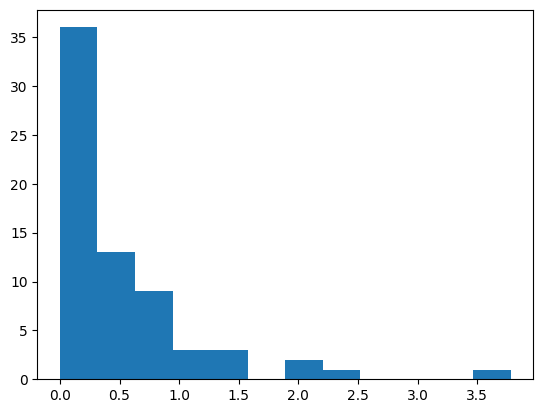


BETA SUMMARY:
beta initial:  [ 8.  7.  7.  7.  7.  7.  8.  7. 10.  7.]
beta final:  [ 8. 20.  7.  7. 20. 20. 20. 20. 20. 20.]


/home/dsemchin/Progression_models_simulations/EMDPM/visualization.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


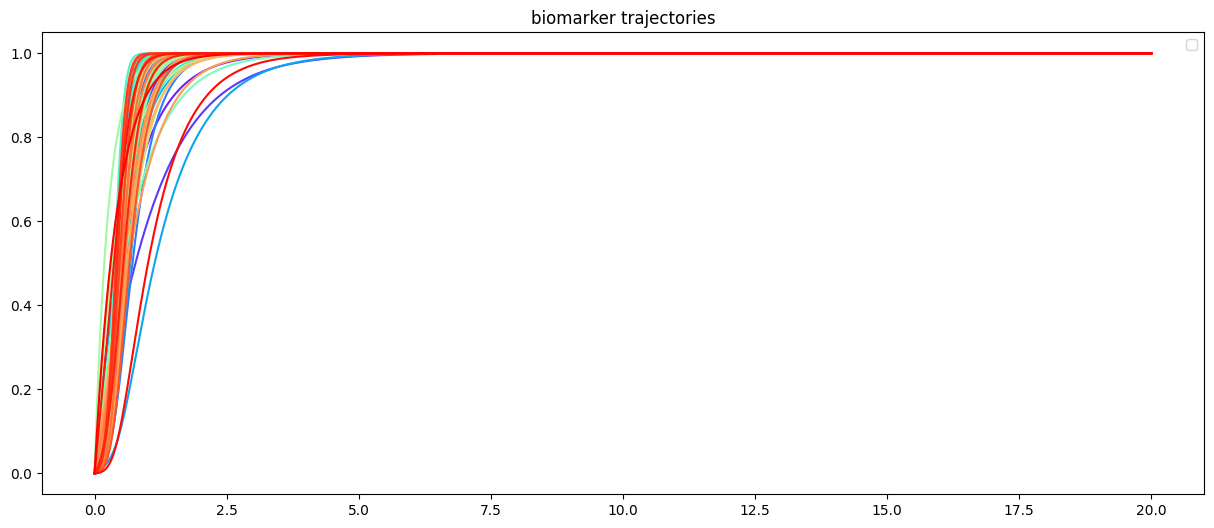

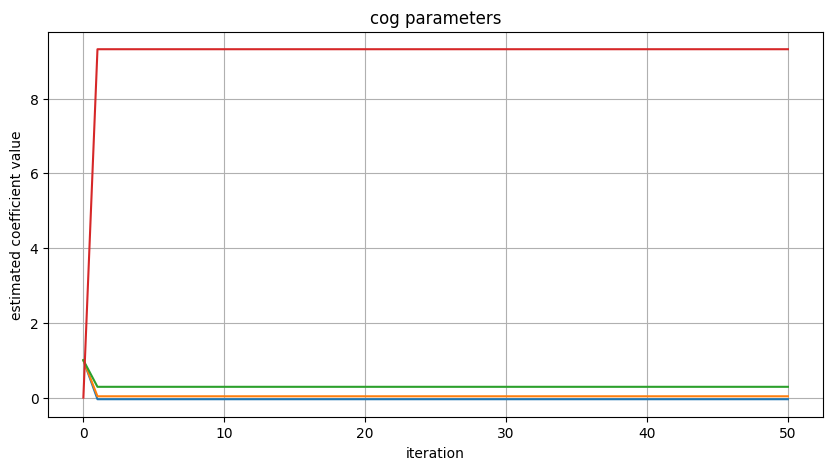

In [ ]:
n_biomarkers = 68
t_span = np.linspace(0, t_max, int(t_max/step))

theta_history = em_model_2.theta_history
beta_history = em_model_2.beta_history
lse_history = em_model_2.lse_history

# final params
final_theta = theta_history[:,-1]
final_x0 = np.zeros(n_biomarkers)
final_f = final_theta[0:n_biomarkers]
final_s = final_theta[n_biomarkers:2*n_biomarkers]
final_scalar_K = final_theta[-1]
final_model = solve_system(final_x0, final_f, K, t_span, final_scalar_K)

initial_theta = theta_history[:,0]
initial_x0 = np.zeros(n_biomarkers)
initial_f = initial_theta[0:n_biomarkers]
initial_s = initial_theta[n_biomarkers:2*n_biomarkers]
initial_scalar_K = initial_theta[-1]
#initial_model = solve_system(initial_x0, initial_f, K, t_span, initial_scalar_K)

print("initial theta:")
print("f: ", np.round(initial_theta[:n_biomarkers], 3)[0:10])
print("s: ", np.round(initial_theta[n_biomarkers:2*n_biomarkers], 3)[0:10])
print("s_k: ", initial_theta[-1])

print("final theta:")
print("f: ", np.round(final_theta[:n_biomarkers], 3)[0:10])
print("s: ", np.round(final_theta[n_biomarkers:2*n_biomarkers], 3)[0:10])
print("s_k: ", final_theta[-1])

zeros = np.sum(final_theta[:n_biomarkers] == 0.0)
print(f"n_zeros: {zeros}")
plt.figure()
plt.hist(final_theta[:n_biomarkers], bins=12) 
plt.show()

## Beta comparison:
print("\nBETA SUMMARY:")
print("beta initial: ", np.round(beta_history[0:10, 0], 3))
print("beta final: ", np.round(beta_history[0:10, -1], 3))

plot_biomarker_trajectories(final_model, t_span, n_biomarkers)
plot_cog_regression_history(em_model_0.cog_regression_history, ["MCATOT","TD_score","PIGD_score"])

In [ ]:
path = "/home/dsemchin/Progression_models_simulations/EMDPM/experiments/real_data_PPMI/ppmi_iter50_jac1_cog01_f05_sk1_betaNN"
em_model_3 = EM(num_iterations=50, t_max=t_max, step=step,
                 use_jacobian=True, lambda_cog=0.1, lambda_f=0.5, lambda_scalar=1)
em_model_3.fit(X=X, dt=dt, ids=ids, cog=cog, K=K, save_path=path, initial_beta=initial_beta)

initial conditions:
n_patients: 146, n_obs: 504
initial f: [0.02132917 0.0153129  0.06642505 0.06843318 0.09331644 0.075149
 0.09268624 0.09472834 0.0866778  0.0012602  0.04133209 0.08230453
 0.0022666  0.01390147 0.09860839 0.09937478 0.08214235 0.08432822
 0.04013177 0.06671307 0.08373361 0.09839783 0.02023919 0.03501122
 0.04284144 0.01783596 0.09961038 0.09075806 0.02514527 0.00911193
 0.08359398 0.01764515 0.01661423 0.07885973 0.07766215 0.04404987
 0.09696822 0.082177   0.05962018 0.00122331 0.05374854 0.04256232
 0.04619497 0.04704044 0.02556865 0.01364169 0.04599744 0.07974691
 0.07593373 0.03570143 0.06885477 0.07627636 0.07265386 0.08249544
 0.09601051 0.04935155 0.06479739 0.06791427 0.02254441 0.00444622
 0.03445908 0.07018692 0.06961764 0.09191688 0.02265776 0.09207324
 0.06548166 0.07676195]
initial s: [0.10711755 0.28260825 2.16554111 1.09902366 1.78421727 2.15874837
 1.36243194 1.69084338 2.16695433 1.00498682 0.94543585 1.55525368
 2.5998545  1.57441885 1.22037802 2.6
















































100%|██████████| 50/50 [14:11<00:00, 17.02s/it]


SUMMARY:
initial theta:  [0.02132917 0.0153129  0.06642505 0.06843318 0.09331644 0.075149
 0.09268624 0.09472834 0.0866778  0.0012602 ]
final theta:  [4.27550460e-07 1.28070624e-08 1.89872335e-01 7.92323862e-01
 2.92670940e-05 1.10994784e+00 6.32461339e-08 8.63200883e-07
 2.57039534e-07 1.41383725e-09]
Saved histories to /home/dsemchin/Progression_models_simulations/EMDPM/experiments/real_data_PPMI/ppmi_iter50_jac0_cog1_lab01_NN.npz


EM(lambda_cog=1.0, lamda=0.1, rng=Generator(PCG64) at 0x7F56243EE180,
   step=0.001, t_max=20, use_jacobian=True)

initial theta:
f:  [0.021 0.015 0.066 0.068 0.093 0.075 0.093 0.095 0.087 0.001]
s:  [0.107 0.283 2.166 1.099 1.784 2.159 1.362 1.691 2.167 1.005]
s_k:  4.149
final theta:
f:  [0.    0.    0.19  0.792 0.    1.11  0.    0.    0.    0.   ]
s:  [2.386 2.335 2.437 1.899 3.136 2.624 2.323 2.639 2.205 2.156]
s_k:  5.004486865124351
n_zeros: 2


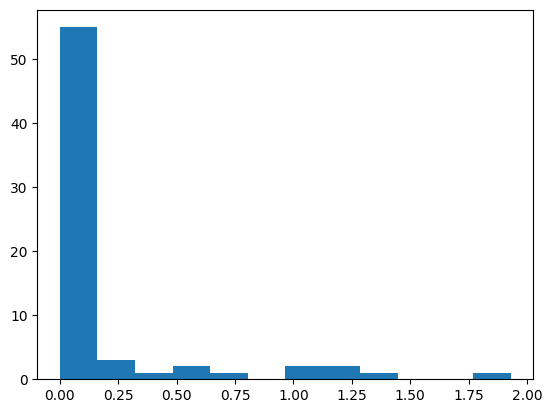


BETA SUMMARY:
beta initial:  [12. 20.  7.  7. 20. 20. 20. 20. 20. 20.]
beta final:  [11. 20.  7.  7. 20. 20. 20. 20. 14. 20.]


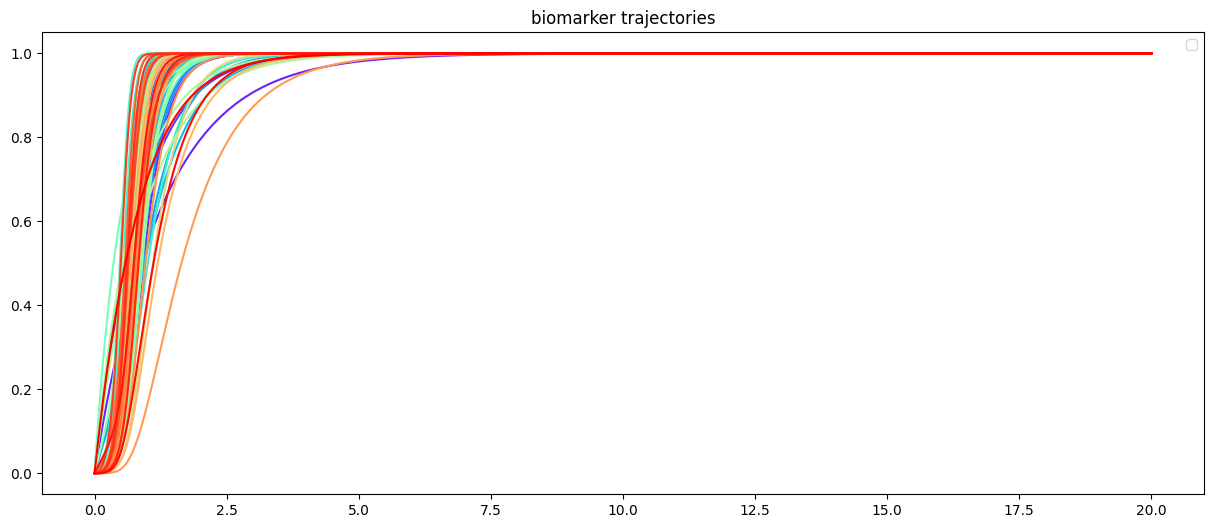

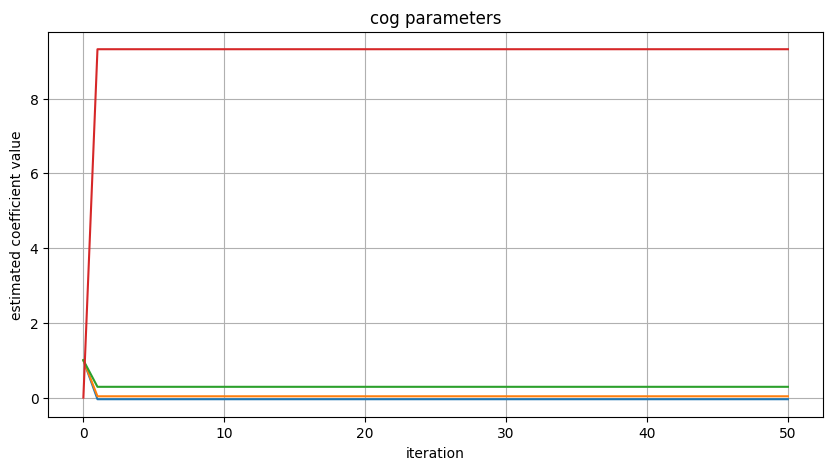

In [ ]:
n_biomarkers = 68
t_span = np.linspace(0, t_max, int(t_max/step))

theta_history = em_model_3.theta_history
beta_history = em_model_3.beta_history
lse_history = em_model_3.lse_history

# final params
final_theta = theta_history[:,-1]
final_x0 = np.zeros(n_biomarkers)
final_f = final_theta[0:n_biomarkers]
final_s = final_theta[n_biomarkers:2*n_biomarkers]
final_scalar_K = final_theta[-1]
final_model = solve_system(final_x0, final_f, K, t_span, final_scalar_K)

initial_theta = theta_history[:,0]
initial_x0 = np.zeros(n_biomarkers)
initial_f = initial_theta[0:n_biomarkers]
initial_s = initial_theta[n_biomarkers:2*n_biomarkers]
initial_scalar_K = initial_theta[-1]
#initial_model = solve_system(initial_x0, initial_f, K, t_span, initial_scalar_K)

print("initial theta:")
print("f: ", np.round(initial_theta[:n_biomarkers], 3)[0:10])
print("s: ", np.round(initial_theta[n_biomarkers:2*n_biomarkers], 3)[0:10])
print("s_k: ", initial_theta[-1])

print("final theta:")
print("f: ", np.round(final_theta[:n_biomarkers], 3)[0:10])
print("s: ", np.round(final_theta[n_biomarkers:2*n_biomarkers], 3)[0:10])
print("s_k: ", final_theta[-1])

zeros = np.sum(final_theta[:n_biomarkers] == 0.0)
print(f"n_zeros: {zeros}")
plt.figure()
plt.hist(final_theta[:n_biomarkers], bins=12) 
plt.show()

## Beta comparison:
print("\nBETA SUMMARY:")
print("beta initial: ", np.round(beta_history[0:10, 0], 3))
print("beta final: ", np.round(beta_history[0:10, -1], 3))

plot_biomarker_trajectories(final_model, t_span, n_biomarkers)
plot_cog_regression_history(em_model_0.cog_regression_history, ["MCATOT","TD_score","PIGD_score"])